## 1. Import Library

In [2]:
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
from optuna.integration import lightgbm as opt_lgb
import optuna
import matplotlib.pyplot as plt

warnings.simplefilter('ignore', pd.core.common.SettingWithCopyWarning)
warnings.simplefilter('ignore', UserWarning)

## 2. Load data

In [3]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")
df_sample_sub = pd.read_csv("../data/sample_submit.csv")
df_sample_sub.columns = ["index", "genre"]
df_genre_labels = pd.read_csv("../data/genre_labels.csv")

## 3. Preparation

In [4]:
N_CLASSES = 11

In [5]:
def merge_train_test(df_train, df_test):
    if "genre" not in df_test.columns.tolist():
        df_test["genre"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

def split_train_test(df):
    df_train = df[df["genre"] != -100]
    df_test = df[df["genre"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

df = merge_train_test(df_train, df_test)

### 4. Feature Engineering

### 4-1. 基本的な操作
- lgbm_knn_baselineと同様
    - tempo : tempo(meanで置き換え), tempo_low, tempo_high, tempo_div
    - region : one-hot-encoding, CE_region(count-encoding), LE_region(label-encoding)
    - num_nans
- 新たに追加
    - tempo : tempo_sum, tempo_diff
    - popularity : popularity01, popularity10

In [6]:
# genre_name
df["genre_name"] = df["genre"].map(dict(df_genre_labels[["labels", "genre"]].values))

# tempo
tempo = df["tempo"].str.split("-").apply(pd.Series).astype(float)
tempo.columns = ["tempo_low", "tempo_high"]
df = pd.concat([df, tempo], axis=1)

df["tempo_sum"] = df["tempo_low"] + tempo["tempo_high"]
df["tempo_diff"] = df["tempo_high"] - tempo["tempo_low"]
df["tempo_div"] = df["tempo_low"] / tempo["tempo_high"]

# df["tempo_low"] = df["tempo_low"].replace(0.0, 0.001)
df["tempo"] = df["tempo"].map(lambda x: sum(map(int, x.split("-"))) / 2)

# region
df = pd.concat([df, pd.get_dummies(df["region"]).rename(columns={"unknown": "region_unknown"})], axis=1)

# num_nans
df["num_nans"] = 0
for col in ["acousticness", "positiveness", 
            "danceability", "energy", "liveness", 
            "speechiness", "instrumentalness"]:
    df["num_nans"] += df[col].isna()
    

# popularity
popularity = df["popularity"].astype(str).str.zfill(2)
popularity = [[i[0], i[1]] for i in popularity]
popularity = pd.DataFrame(popularity, columns=["popularity10", "popularity01"])
popularity = popularity.astype(int)
df = pd.concat([df, popularity], axis=1)
df

,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,...,region_O,region_P,region_Q,region_R,region_S,region_T,region_unknown,num_nans,popularity10,popularity01
0,0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,...,0,0,0,0,0,0,0,0,1,1
1,1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,...,0,0,0,0,0,0,0,0,6,9
2,2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,...,0,0,0,0,0,0,0,0,4,3
3,3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,...,0,0,0,0,0,0,0,0,4,5
4,4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,...,0,0,0,0,0,0,1,0,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8087,8087,-100,34,366668,0.117208,0.316026,0.502289,-2.909329,0.824708,0.320241,...,0,0,0,0,0,0,0,0,3,4
8088,8088,-100,53,240081,0.225540,0.391226,0.483655,-5.013634,0.630808,0.163884,...,0,0,0,0,0,0,0,0,5,3
8089,8089,-100,48,217839,0.215571,0.828567,0.689747,-8.974036,0.697981,0.318250,...,0,0,0,0,0,0,0,0,4,8
8090,8090,-100,45,249612,0.205074,0.730554,0.580581,-1.915320,0.828423,0.360663,...,0,0,0,0,0,0,0,0,4,5


### 4-2. Encoder
- CountEncoder : region
- LabelEncoder : region

In [7]:
class CountEncoder:
    def fit(self, series):
        self.counts = series.groupby(series).count()
        return self
    
    def transform(self, series):
        return series.map(self.counts).fillna(0)
    
    def fit_transform(self, series):
        return self.fit(series).transform(series)
    
columns_count_enc = ["region"]
for col in columns_count_enc:
    df["CE_" + col] = CountEncoder().fit_transform(df[col])
    df.loc[df[col].isna().values, "CE_" + col] = np.nan


columns_label_enc = ["region"]
for col in columns_count_enc:
    df["LE_" + col] = LabelEncoder().fit_transform(df[col])
    df.loc[df[col].isna().values, "LE_" + col] = np.nan

df

,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,...,region_Q,region_R,region_S,region_T,region_unknown,num_nans,popularity10,popularity01,CE_region,LE_region
0,0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,...,0,0,0,0,0,0,1,1,385.0,7.0
1,1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,...,0,0,0,0,0,0,6,9,1573.0,8.0
2,2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,...,0,0,0,0,0,0,4,3,1353.0,4.0
3,3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,...,0,0,0,0,0,0,4,5,171.0,2.0
4,4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,...,0,0,0,0,1,0,5,7,696.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8087,8087,-100,34,366668,0.117208,0.316026,0.502289,-2.909329,0.824708,0.320241,...,0,0,0,0,0,0,3,4,673.0,1.0
8088,8088,-100,53,240081,0.225540,0.391226,0.483655,-5.013634,0.630808,0.163884,...,0,0,0,0,0,0,5,3,1573.0,8.0
8089,8089,-100,48,217839,0.215571,0.828567,0.689747,-8.974036,0.697981,0.318250,...,0,0,0,0,0,0,4,8,385.0,7.0
8090,8090,-100,45,249612,0.205074,0.730554,0.580581,-1.915320,0.828423,0.360663,...,0,0,0,0,0,0,4,5,673.0,1.0


### 4-3. 集約特徴量
- regionの集約特徴量を作成
- min, mean, max, median, std, max-min, q75-q25, zscore

In [8]:
class GroupFeatureExtractor:  # 参考: https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    EX_TRANS_METHODS = ["deviation", "zscore"]
    
    def __init__(self, group_key, group_values, agg_methods):
        self.group_key = group_key
        self.group_values = group_values

        self.ex_trans_methods = [m for m in agg_methods if m in self.EX_TRANS_METHODS]
        self.agg_methods = [m for m in agg_methods if m not in self.ex_trans_methods]
        self.df_agg = None

    def fit(self, df_train, y=None):
        if not self.agg_methods:
            return
        dfs = []
        for agg_method in self.agg_methods:
            if callable(agg_method):
                agg_method_name = agg_method.__name__
            else:
                agg_method_name = agg_method
            df_agg = (df_train[[self.group_key] + self.group_values].groupby(self.group_key).agg(agg_method))
            df_agg.columns = self._get_column_names(agg_method_name)
            dfs.append(df_agg)
        self.df_agg = pd.concat(dfs, axis=1).reset_index()

    def transform(self, df_eval):
        key = self.group_key
        if self.agg_methods:
            df_features = pd.merge(df_eval[[self.group_key]], self.df_agg, on=self.group_key, how="left")
        else:
            df_features = df_eval[[self.group_key]].copy()
        if self.ex_trans_methods:
            if "deviation" in self.ex_trans_methods:
                df_features[self._get_agg_column_names("deviation")] = df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")
            if "zscore" in self.ex_trans_methods:
                df_features[self._get_column_names("zscore")] = (df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")) \
                                                                / (df_eval[[key]+self.group_values].groupby(key).transform("std") + 1e-8)
        df_features.drop(self.group_key, axis=1, inplace=True)
        return df_features

    def _get_column_names(self, method):
        return [f"agg_{method}_{col}_grpby_{self.group_key}" for col in self.group_values]

    def fit_transform(self, df_train, y=None):
        self.fit(df_train, y=y)
        return self.transform(df_train)   

# 集約特徴量作成時に使用
def max_min(x):
    return x.max() - x.min()

def q75_q25(x):
    return x.quantile(0.75) - x.quantile(0.25)
    
gfe = GroupFeatureExtractor(
    "region", 
    ['popularity', 'duration_ms', 'acousticness', 'positiveness', 
     'danceability', 'loudness', 'energy', 'liveness', 'speechiness', 
     'instrumentalness',
     'tempo', 'tempo_low', 'tempo_high',
     'popularity10', 'popularity01'], 
    ["min", "mean", "max", "median", "std", max_min, q75_q25, "zscore"]
)
df = pd.concat([df, gfe.fit_transform(df)], axis=1)
df

,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,...,agg_zscore_loudness_grpby_region,agg_zscore_energy_grpby_region,agg_zscore_liveness_grpby_region,agg_zscore_speechiness_grpby_region,agg_zscore_instrumentalness_grpby_region,agg_zscore_tempo_grpby_region,agg_zscore_tempo_low_grpby_region,agg_zscore_tempo_high_grpby_region,agg_zscore_popularity10_grpby_region,agg_zscore_popularity01_grpby_region
0,0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,...,1.512742,1.361700,0.538449,2.294931,3.791753,0.511301,0.418672,0.591510,-1.159327,-1.044247
1,1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,...,0.481851,1.326272,-0.499695,-0.500337,-0.587831,1.414210,1.479560,1.342325,1.425982,1.663014
2,2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,...,-0.488448,-0.808778,-0.288703,1.980912,-0.252552,-1.797012,-1.634219,-1.934995,0.048978,-0.599708
3,3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,...,0.312116,0.993184,0.833359,0.436282,-0.293784,1.817014,1.989646,1.634625,0.290296,0.103498
4,4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,...,0.953197,0.195902,-0.617285,0.206761,0.088274,-0.510415,-0.496445,-0.519646,0.805682,0.951385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8087,8087,-100,34,366668,0.117208,0.316026,0.502289,-2.909329,0.824708,0.320241,...,1.146514,0.970917,0.342260,0.222365,-0.121337,0.442081,0.345447,0.528850,-0.282831,-0.117197
8088,8088,-100,53,240081,0.225540,0.391226,0.483655,-5.013634,0.630808,0.163884,...,0.621439,0.050088,-0.688451,-0.007002,-0.156765,0.476541,0.374030,0.568536,0.825106,-0.433637
8089,8089,-100,48,217839,0.215571,0.828567,0.689747,-8.974036,0.697981,0.318250,...,-0.152429,0.484505,0.268481,-0.906510,-0.572775,0.511301,0.418672,0.591510,0.609527,1.448442
8090,8090,-100,45,249612,0.205074,0.730554,0.580581,-1.915320,0.828423,0.360663,...,1.383579,0.988935,0.595628,-0.343720,-0.360130,0.442081,0.345447,0.528850,0.353776,0.221316


### 4-4. KNN

In [9]:
class KNNFeatureExtractor:
    def __init__(self, n_neighbors=5):
        self.knn = KNeighborsClassifier(n_neighbors + 1)
    
    def fit(self, X, y):
        self.knn.fit(X, y)
        self.y = y if isinstance(y, np.ndarray) else np.array(y)
        return self
    
    def transform(self, X, is_train_data):
        distances, indexes = self.knn.kneighbors(X)
        distances = distances[:, 1:] if is_train_data else distances[:, :-1]
        indexes = indexes[:, 1:] if is_train_data else indexes[:, :-1]
        labels = self.y[indexes]
        score_columns = [f"knn_score_class{c:02d}" for c in range(N_CLASSES)]
        df_knn = pd.DataFrame(
            [np.bincount(labels_, distances_, N_CLASSES) for labels_, distances_ in zip(labels, 1.0 / distances)],
            columns=score_columns
        )
        df_knn["max_knn_scores"] = df_knn.max(1)
        for col in score_columns:
            df_knn[f"sub_max_knn_scores_{col}"] = df_knn["max_knn_scores"] - df_knn[col]
        for i, col1 in enumerate(score_columns):
            for j, col2 in enumerate(score_columns[i+1:], i+1):
                if {i, j} & {8, 10}:
                    df_knn[f"sub_{col1}_{col2}"] = df_knn[col1] - df_knn[col2]
        df_knn["sum_knn_scores"] = df_knn.sum(1)
        
        return df_knn

In [10]:
# feature scaling

df["log_tempo"] = np.log(df["tempo"])

for col in ['popularity', 'duration_ms', 'acousticness', 
            'positiveness', 'danceability', 'loudness', 
            'energy', 'liveness', 'speechiness', 'instrumentalness', 
            'log_tempo', 'num_nans']:
    df["standardscaled_" + col] = StandardScaler().fit_transform(df[[col]])[:, 0]

In [11]:
df_train, df_test = split_train_test(df)
target = df_train["genre"]

In [12]:
# feature weights

knn_features = ['region_A', 'region_B', 'region_C', 'region_D', 'region_E', 
            'region_F', 'region_G', 'region_H', 'region_I', 'region_J', 
            'region_K', 'region_L', 'region_M', 'region_N', 'region_O', 
            'region_P', 'region_Q', 'region_R', 'region_S', 'region_T',
            'region_unknown', 'standardscaled_popularity', 'standardscaled_duration_ms',
            'standardscaled_acousticness', 'standardscaled_positiveness',
            'standardscaled_danceability', 'standardscaled_loudness', 'standardscaled_energy',
            'standardscaled_liveness', 'standardscaled_speechiness', 'standardscaled_instrumentalness',
            'standardscaled_log_tempo',
            'standardscaled_num_nans']

dict_feature_weights = {}

for col in knn_features[:21]:
    dict_feature_weights[col] = 100.0

for col in ['standardscaled_duration_ms', 'standardscaled_acousticness', 'standardscaled_positiveness',
            'standardscaled_danceability', 'standardscaled_loudness', 'standardscaled_energy',
            'standardscaled_liveness', 'standardscaled_speechiness', 'standardscaled_instrumentalness']:
    dict_feature_weights[col] = 1.0

dict_feature_weights["standardscaled_popularity"] = 8.0
dict_feature_weights["standardscaled_log_tempo"] = 0.001
dict_feature_weights["standardscaled_num_nans"] = 100.0

knn_feature_weights = np.array([dict_feature_weights[col] for col in knn_features])

## 5. Training
- optunaを用いてパラメータチューニング
- CrossValidation (n_splits=15)で学習

In [13]:
# parameters

learning_rate = 0.01
lgb_params = {
    "objective": "multiclass",
    "num_class": N_CLASSES,
    "metric": "multiclass",
    "learning_rate": learning_rate,
    "verbosity": -1,
    "seed": 42,
}

knn_n_neighbors = 6

In [14]:
N_SPLITS = 15
SEED_SKF = 42
np.random.seed(42)

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
oof = np.zeros((len(df_train), N_CLASSES))
predictions = np.zeros((len(df_test), N_CLASSES))
df_feature_importance = pd.DataFrame()


features_numerical = [
    'popularity', 'duration_ms', 'acousticness',
    'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
    'speechiness', 'instrumentalness', 
    'tempo', 'tempo_low', 'tempo_high',
    'tempo_sum', 'tempo_diff', 'tempo_div',
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
    'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
    'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
    'region_S', 'region_T', 'region_unknown', 
    'CE_region',
    'num_nans',
    'popularity01', 'popularity10',
    # z-score
    'agg_zscore_popularity_grpby_region',
    'agg_zscore_duration_ms_grpby_region',
    'agg_zscore_acousticness_grpby_region',
    'agg_zscore_positiveness_grpby_region',
    'agg_zscore_danceability_grpby_region',
    'agg_zscore_loudness_grpby_region', 'agg_zscore_energy_grpby_region',
    'agg_zscore_liveness_grpby_region',
    'agg_zscore_speechiness_grpby_region',
    'agg_zscore_instrumentalness_grpby_region',
    'agg_zscore_tempo_grpby_region',
    'agg_zscore_tempo_low_grpby_region',
    'agg_zscore_tempo_high_grpby_region',
    'agg_zscore_popularity10_grpby_region',
    'agg_zscore_popularity01_grpby_region',
    # min
    'agg_min_popularity_grpby_region',
    'agg_min_duration_ms_grpby_region',
    'agg_min_acousticness_grpby_region',
    'agg_min_positiveness_grpby_region',
    'agg_min_danceability_grpby_region',
    'agg_min_loudness_grpby_region',
    'agg_min_energy_grpby_region',
    'agg_min_liveness_grpby_region',
    'agg_min_speechiness_grpby_region',
    'agg_min_instrumentalness_grpby_region',
    'agg_min_tempo_grpby_region',
    'agg_min_tempo_low_grpby_region',
    'agg_min_tempo_high_grpby_region',
    'agg_min_popularity10_grpby_region',
    'agg_min_popularity01_grpby_region',
    # mean
    'agg_mean_popularity_grpby_region',
    'agg_mean_duration_ms_grpby_region',
    'agg_mean_acousticness_grpby_region',
    'agg_mean_positiveness_grpby_region',
    'agg_mean_danceability_grpby_region',
    'agg_mean_loudness_grpby_region',
    'agg_mean_energy_grpby_region',
    'agg_mean_liveness_grpby_region',
    'agg_mean_speechiness_grpby_region',
    'agg_mean_instrumentalness_grpby_region',
    'agg_mean_tempo_grpby_region',
    'agg_mean_tempo_low_grpby_region',
    'agg_mean_tempo_high_grpby_region',
    'agg_mean_popularity10_grpby_region',
    'agg_mean_popularity01_grpby_region',
    # max
    'agg_max_popularity_grpby_region',
    'agg_max_duration_ms_grpby_region',
    'agg_max_acousticness_grpby_region',
    'agg_max_positiveness_grpby_region',
    'agg_max_danceability_grpby_region',
    'agg_max_loudness_grpby_region',
    'agg_max_energy_grpby_region',
    'agg_max_liveness_grpby_region',
    'agg_max_speechiness_grpby_region',
    'agg_max_instrumentalness_grpby_region',
    'agg_max_tempo_grpby_region',
    'agg_max_tempo_low_grpby_region',
    'agg_max_tempo_high_grpby_region',
    'agg_max_popularity10_grpby_region',
    'agg_max_popularity01_grpby_region',
    # median
    'agg_median_popularity_grpby_region',
    'agg_median_duration_ms_grpby_region',
    'agg_median_acousticness_grpby_region',
    'agg_median_positiveness_grpby_region',
    'agg_median_danceability_grpby_region',
    'agg_median_loudness_grpby_region',
    'agg_median_energy_grpby_region',
    'agg_median_liveness_grpby_region',
    'agg_median_speechiness_grpby_region',
    'agg_median_instrumentalness_grpby_region',
    'agg_median_tempo_grpby_region',
    'agg_median_tempo_low_grpby_region',
    'agg_median_tempo_high_grpby_region',
    'agg_median_popularity10_grpby_region',
    'agg_median_popularity01_grpby_region',
    # std
    'agg_std_popularity_grpby_region',
    'agg_std_duration_ms_grpby_region',
    'agg_std_acousticness_grpby_region',
    'agg_std_positiveness_grpby_region',
    'agg_std_danceability_grpby_region',
    'agg_std_loudness_grpby_region',
    'agg_std_energy_grpby_region',
    'agg_std_liveness_grpby_region',
    'agg_std_speechiness_grpby_region',
    'agg_std_instrumentalness_grpby_region',
    'agg_std_tempo_grpby_region',
    'agg_std_popularity10_grpby_region',
    'agg_std_popularity01_grpby_region',
    # max_min
    'agg_max_min_popularity_grpby_region',
    'agg_max_min_duration_ms_grpby_region',
    'agg_max_min_acousticness_grpby_region',
    'agg_max_min_positiveness_grpby_region',
    'agg_max_min_danceability_grpby_region',
    'agg_max_min_loudness_grpby_region',
    'agg_max_min_energy_grpby_region',
    'agg_max_min_liveness_grpby_region',
    'agg_max_min_speechiness_grpby_region',
    'agg_max_min_instrumentalness_grpby_region',
    'agg_max_min_tempo_grpby_region',
    'agg_max_min_tempo_low_grpby_region',
    'agg_max_min_tempo_high_grpby_region',
    'agg_max_min_popularity10_grpby_region',
    'agg_max_min_popularity01_grpby_region',
    # q75_q25
    'agg_q75_q25_popularity_grpby_region',
    'agg_q75_q25_duration_ms_grpby_region',
    'agg_q75_q25_acousticness_grpby_region',
    'agg_q75_q25_positiveness_grpby_region',
    'agg_q75_q25_danceability_grpby_region',
    'agg_q75_q25_loudness_grpby_region',
    'agg_q75_q25_energy_grpby_region',
    'agg_q75_q25_liveness_grpby_region',
    'agg_q75_q25_speechiness_grpby_region',
    'agg_q75_q25_instrumentalness_grpby_region',
    'agg_q75_q25_tempo_grpby_region',
    'agg_q75_q25_tempo_low_grpby_region',
    'agg_q75_q25_tempo_high_grpby_region',
    'agg_q75_q25_popularity10_grpby_region',
    'agg_q75_q25_popularity01_grpby_region',
    # knn
    'knn_score_class00', 'knn_score_class01',
    'knn_score_class02', 'knn_score_class03', 'knn_score_class04',
    'knn_score_class05', 'knn_score_class06', 'knn_score_class07',
    'knn_score_class08', 'knn_score_class09', 'knn_score_class10',
    'max_knn_scores',
    'sub_max_knn_scores_knn_score_class00',
    'sub_max_knn_scores_knn_score_class01',
    'sub_max_knn_scores_knn_score_class02',
    'sub_max_knn_scores_knn_score_class03',
    'sub_max_knn_scores_knn_score_class04',
    'sub_max_knn_scores_knn_score_class05',
    'sub_max_knn_scores_knn_score_class06',
    'sub_max_knn_scores_knn_score_class07',
    'sub_max_knn_scores_knn_score_class08',
    'sub_max_knn_scores_knn_score_class09',
    'sub_max_knn_scores_knn_score_class10',
    'sub_knn_score_class00_knn_score_class08',
    'sub_knn_score_class00_knn_score_class10',
    'sub_knn_score_class01_knn_score_class08',
    'sub_knn_score_class01_knn_score_class10',
    'sub_knn_score_class02_knn_score_class08',
    'sub_knn_score_class02_knn_score_class10',
    'sub_knn_score_class03_knn_score_class08',
    'sub_knn_score_class03_knn_score_class10',
    'sub_knn_score_class04_knn_score_class08',
    'sub_knn_score_class04_knn_score_class10',
    'sub_knn_score_class05_knn_score_class08',
    'sub_knn_score_class05_knn_score_class10',
    'sub_knn_score_class06_knn_score_class08',
    'sub_knn_score_class06_knn_score_class10',
    'sub_knn_score_class07_knn_score_class08',
    'sub_knn_score_class07_knn_score_class10',
    'sub_knn_score_class08_knn_score_class09',
    'sub_knn_score_class08_knn_score_class10',
    'sub_knn_score_class09_knn_score_class10',
    'sum_knn_scores'
]
features_categorical = ["LE_region"]
features = features_numerical + features_categorical
print(len(features))

203


In [378]:
# Optunaを用いたパラメータチューニング (鬼のように時間がかかるので注意)

# make knn features
X = df_train[knn_features].fillna(0.0).values * knn_feature_weights
knn_feature_extractor = KNNFeatureExtractor(knn_n_neighbors).fit(X, target)
_df_train = pd.concat([df_train, knn_feature_extractor.transform(X, is_train_data=True)], axis=1)
print(f"特徴量数: {_df_train.loc[:, features].shape[-1]}")

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED_SKF)

lgb_train = opt_lgb.Dataset(
    _df_train.loc[:, features],
    label=target,
    feature_name=features,
    categorical_feature=features_categorical
    )

tuner_cv = opt_lgb.LightGBMTunerCV(
    lgb_params,
    lgb_train,
    num_boost_round=10000000,
    early_stopping_rounds=300,
    verbose_eval=300,
    folds=folds,
    )
tuner_cv.run()

# 最も良かったスコアとパラメータを書き出す
print(f'Best score: {tuner_cv.best_score}')
print(f'Best params: {tuner_cv.best_params}')

[I 2021-04-29 17:53:21,921] A new study created in memory with name: no-name-bdcaab5f-2104-45a5-863a-a254a41039be

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

特徴量数: 203
[300]	cv_agg's multi_logloss: 0.851184 + 0.0437258



feature_fraction, val_score: 0.835432:  14%|#4        | 1/7 [03:33<21:21, 213.62s/it][I 2021-04-29 17:56:55,559] Trial 0 finished with value: 0.8354322005989733 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.8354322005989733.

feature_fraction, val_score: 0.835432:  14%|#4        | 1/7 [03:33<21:21, 213.62s/it]

[300]	cv_agg's multi_logloss: 0.856162 + 0.0449726



feature_fraction, val_score: 0.835432:  29%|##8       | 2/7 [07:16<18:16, 219.21s/it][I 2021-04-29 18:00:38,683] Trial 1 finished with value: 0.8395965507862213 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.8354322005989733.

feature_fraction, val_score: 0.835432:  29%|##8       | 2/7 [07:16<18:16, 219.21s/it]

[300]	cv_agg's multi_logloss: 0.858051 + 0.0442191



feature_fraction, val_score: 0.835432:  43%|####2     | 3/7 [11:16<15:15, 228.79s/it][I 2021-04-29 18:04:38,869] Trial 2 finished with value: 0.8416929079964349 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.8354322005989733.

feature_fraction, val_score: 0.835432:  43%|####2     | 3/7 [11:16<15:15, 228.79s/it]

[300]	cv_agg's multi_logloss: 0.838345 + 0.0418343



feature_fraction, val_score: 0.827354:  57%|#####7    | 4/7 [14:22<10:35, 211.72s/it][I 2021-04-29 18:07:44,412] Trial 3 finished with value: 0.82735398075315 and parameters: {'feature_fraction': 0.5}. Best is trial 3 with value: 0.82735398075315.

feature_fraction, val_score: 0.827354:  57%|#####7    | 4/7 [14:22<10:35, 211.72s/it]

[300]	cv_agg's multi_logloss: 0.8332 + 0.0386748



feature_fraction, val_score: 0.825237:  71%|#######1  | 5/7 [17:19<06:38, 199.07s/it][I 2021-04-29 18:10:41,048] Trial 4 finished with value: 0.8252372358770558 and parameters: {'feature_fraction': 0.4}. Best is trial 4 with value: 0.8252372358770558.

feature_fraction, val_score: 0.825237:  71%|#######1  | 5/7 [17:19<06:38, 199.07s/it]

[300]	cv_agg's multi_logloss: 0.844417 + 0.0428335



feature_fraction, val_score: 0.825237:  86%|########5 | 6/7 [21:07<03:29, 209.10s/it][I 2021-04-29 18:14:29,620] Trial 5 finished with value: 0.8303696499886442 and parameters: {'feature_fraction': 0.7}. Best is trial 4 with value: 0.8252372358770558.

feature_fraction, val_score: 0.825237:  86%|########5 | 6/7 [21:07<03:29, 209.10s/it]

[300]	cv_agg's multi_logloss: 0.841434 + 0.0427831



feature_fraction, val_score: 0.825237: 100%|##########| 7/7 [24:24<00:00, 209.19s/it]

num_leaves, val_score: 0.825237:   0%|          | 0/20 [00:00<?, ?it/s]

[300]	cv_agg's multi_logloss: 0.853521 + 0.0402132



num_leaves, val_score: 0.825237:   5%|5         | 1/20 [08:27<2:40:36, 507.17s/it][I 2021-04-29 18:26:13,432] Trial 7 finished with value: 0.8281476731384553 and parameters: {'num_leaves': 180}. Best is trial 7 with value: 0.8281476731384553.

num_leaves, val_score: 0.825237:   5%|5         | 1/20 [08:27<2:40:36, 507.17s/it]

[300]	cv_agg's multi_logloss: 0.852692 + 0.0416205



num_leaves, val_score: 0.825237:  10%|#         | 2/20 [16:43<2:30:17, 500.98s/it][I 2021-04-29 18:34:30,072] Trial 8 finished with value: 0.8279081938899797 and parameters: {'num_leaves': 131}. Best is trial 8 with value: 0.8279081938899797.

num_leaves, val_score: 0.825237:  10%|#         | 2/20 [16:43<2:30:17, 500.98s/it]

[300]	cv_agg's multi_logloss: 0.844063 + 0.0398904



num_leaves, val_score: 0.825237:  15%|#5        | 3/20 [20:37<1:47:21, 378.90s/it][I 2021-04-29 18:38:23,706] Trial 9 finished with value: 0.8274048812222388 and parameters: {'num_leaves': 46}. Best is trial 9 with value: 0.8274048812222388.

num_leaves, val_score: 0.825237:  15%|#5        | 3/20 [20:37<1:47:21, 378.90s/it]

[300]	cv_agg's multi_logloss: 0.852923 + 0.0405462



num_leaves, val_score: 0.825237:  20%|##        | 4/20 [28:05<1:48:19, 406.25s/it][I 2021-04-29 18:45:51,882] Trial 10 finished with value: 0.8272281994434278 and parameters: {'num_leaves': 114}. Best is trial 10 with value: 0.8272281994434278.

num_leaves, val_score: 0.825237:  20%|##        | 4/20 [28:05<1:48:19, 406.25s/it]

[300]	cv_agg's multi_logloss: 0.848362 + 0.0390545



num_leaves, val_score: 0.825237:  25%|##5       | 5/20 [33:28<1:34:04, 376.27s/it][I 2021-04-29 18:51:15,003] Trial 11 finished with value: 0.8275296296381132 and parameters: {'num_leaves': 66}. Best is trial 10 with value: 0.8272281994434278.

num_leaves, val_score: 0.825237:  25%|##5       | 5/20 [33:28<1:34:04, 376.27s/it]

[300]	cv_agg's multi_logloss: 0.853055 + 0.0406513



num_leaves, val_score: 0.825237:  30%|###       | 6/20 [41:54<1:38:06, 420.45s/it][I 2021-04-29 18:59:41,212] Trial 12 finished with value: 0.8278429207362723 and parameters: {'num_leaves': 127}. Best is trial 10 with value: 0.8272281994434278.

num_leaves, val_score: 0.825237:  30%|###       | 6/20 [41:54<1:38:06, 420.45s/it]

[300]	cv_agg's multi_logloss: 0.853542 + 0.0402863



num_leaves, val_score: 0.825237:  35%|###5      | 7/20 [50:22<1:37:16, 448.93s/it][I 2021-04-29 19:08:08,784] Trial 13 finished with value: 0.8281473971654322 and parameters: {'num_leaves': 146}. Best is trial 10 with value: 0.8272281994434278.

num_leaves, val_score: 0.825237:  35%|###5      | 7/20 [50:22<1:37:16, 448.93s/it]

[300]	cv_agg's multi_logloss: 0.829657 + 0.0382638



num_leaves, val_score: 0.824198:  40%|####      | 8/20 [53:01<1:11:19, 356.59s/it][I 2021-04-29 19:10:47,664] Trial 14 finished with value: 0.824197714298095 and parameters: {'num_leaves': 26}. Best is trial 14 with value: 0.824197714298095.

num_leaves, val_score: 0.824198:  40%|####      | 8/20 [53:01<1:11:19, 356.59s/it]

[300]	cv_agg's multi_logloss: 0.834986 + 0.0390917



num_leaves, val_score: 0.824198:  45%|####5     | 9/20 [55:49<54:34, 297.70s/it]  [I 2021-04-29 19:13:35,870] Trial 15 finished with value: 0.8256656647551539 and parameters: {'num_leaves': 32}. Best is trial 14 with value: 0.824197714298095.

num_leaves, val_score: 0.824198:  45%|####5     | 9/20 [55:49<54:34, 297.70s/it]

[300]	cv_agg's multi_logloss: 0.813623 + 0.0340617
[600]	cv_agg's multi_logloss: 0.839282 + 0.0438172



num_leaves, val_score: 0.813591:  50%|#####     | 10/20 [57:16<38:46, 232.66s/it][I 2021-04-29 19:15:02,875] Trial 16 finished with value: 0.8135905569985846 and parameters: {'num_leaves': 11}. Best is trial 16 with value: 0.8135905569985846.

num_leaves, val_score: 0.813591:  50%|#####     | 10/20 [57:16<38:46, 232.66s/it]

[300]	cv_agg's multi_logloss: 0.853521 + 0.0402132



num_leaves, val_score: 0.813591:  55%|#####5    | 11/20 [1:06:52<50:38, 337.56s/it][I 2021-04-29 19:24:38,296] Trial 17 finished with value: 0.8281476731384553 and parameters: {'num_leaves': 256}. Best is trial 16 with value: 0.8135905569985846.

num_leaves, val_score: 0.813591:  55%|#####5    | 11/20 [1:06:52<50:38, 337.56s/it]

[300]	cv_agg's multi_logloss: 0.827754 + 0.0291142
[600]	cv_agg's multi_logloss: 0.816898 + 0.0325276



num_leaves, val_score: 0.813591:  60%|######    | 12/20 [1:07:50<33:42, 252.79s/it][I 2021-04-29 19:25:37,200] Trial 18 finished with value: 0.8164533464049514 and parameters: {'num_leaves': 4}. Best is trial 16 with value: 0.8135905569985846.

num_leaves, val_score: 0.813591:  60%|######    | 12/20 [1:07:50<33:42, 252.79s/it]

[300]	cv_agg's multi_logloss: 0.813623 + 0.0340617
[600]	cv_agg's multi_logloss: 0.839282 + 0.0438172



num_leaves, val_score: 0.813591:  65%|######5   | 13/20 [1:09:19<23:41, 203.13s/it][I 2021-04-29 19:27:06,059] Trial 19 finished with value: 0.8135905569985846 and parameters: {'num_leaves': 11}. Best is trial 16 with value: 0.8135905569985846.

num_leaves, val_score: 0.813591:  65%|######5   | 13/20 [1:09:19<23:41, 203.13s/it]

[300]	cv_agg's multi_logloss: 0.8516 + 0.0397865



num_leaves, val_score: 0.813591:  70%|#######   | 14/20 [1:15:18<25:01, 250.24s/it][I 2021-04-29 19:33:05,166] Trial 20 finished with value: 0.8275361366342351 and parameters: {'num_leaves': 76}. Best is trial 16 with value: 0.8135905569985846.

num_leaves, val_score: 0.813591:  70%|#######   | 14/20 [1:15:18<25:01, 250.24s/it]

[300]	cv_agg's multi_logloss: 0.820935 + 0.0289005
[600]	cv_agg's multi_logloss: 0.816276 + 0.0344634



num_leaves, val_score: 0.813489:  75%|#######5  | 15/20 [1:16:26<16:15, 195.17s/it][I 2021-04-29 19:34:12,703] Trial 21 finished with value: 0.8134887859287592 and parameters: {'num_leaves': 5}. Best is trial 21 with value: 0.8134887859287592.

num_leaves, val_score: 0.813489:  75%|#######5  | 15/20 [1:16:26<16:15, 195.17s/it]

[300]	cv_agg's multi_logloss: 0.852702 + 0.0413724



num_leaves, val_score: 0.813489:  80%|########  | 16/20 [1:22:28<16:21, 245.40s/it][I 2021-04-29 19:40:14,757] Trial 22 finished with value: 0.8277484681606543 and parameters: {'num_leaves': 87}. Best is trial 21 with value: 0.8134887859287592.

num_leaves, val_score: 0.813489:  80%|########  | 16/20 [1:22:28<16:21, 245.40s/it]

[300]	cv_agg's multi_logloss: 0.853521 + 0.0402132



num_leaves, val_score: 0.813489:  85%|########5 | 17/20 [1:30:45<16:02, 320.94s/it][I 2021-04-29 19:48:31,376] Trial 23 finished with value: 0.8281476731384553 and parameters: {'num_leaves': 237}. Best is trial 21 with value: 0.8134887859287592.

num_leaves, val_score: 0.813489:  85%|########5 | 17/20 [1:30:45<16:02, 320.94s/it]

[300]	cv_agg's multi_logloss: 0.827754 + 0.0291142
[600]	cv_agg's multi_logloss: 0.816898 + 0.0325276



num_leaves, val_score: 0.813489:  90%|######### | 18/20 [1:31:40<08:02, 241.24s/it][I 2021-04-29 19:49:27,075] Trial 24 finished with value: 0.8164533464049513 and parameters: {'num_leaves': 4}. Best is trial 21 with value: 0.8134887859287592.

num_leaves, val_score: 0.813489:  90%|######### | 18/20 [1:31:40<08:02, 241.24s/it]

[300]	cv_agg's multi_logloss: 0.844406 + 0.0386773



num_leaves, val_score: 0.813489:  95%|#########5| 19/20 [1:35:26<03:56, 236.53s/it][I 2021-04-29 19:53:12,641] Trial 25 finished with value: 0.8273208614622798 and parameters: {'num_leaves': 47}. Best is trial 21 with value: 0.8134887859287592.

num_leaves, val_score: 0.813489:  95%|#########5| 19/20 [1:35:26<03:56, 236.53s/it]

[300]	cv_agg's multi_logloss: 0.853521 + 0.0402132



num_leaves, val_score: 0.813489: 100%|##########| 20/20 [1:43:00<00:00, 309.03s/it]

bagging, val_score: 0.813489:   0%|          | 0/10 [00:00<?, ?it/s]

[300]	cv_agg's multi_logloss: 0.823028 + 0.0295561
[600]	cv_agg's multi_logloss: 0.821159 + 0.0355888



bagging, val_score: 0.813489:  10%|#         | 1/10 [00:48<07:14, 48.26s/it][I 2021-04-29 20:01:35,170] Trial 27 finished with value: 0.8174383617017569 and parameters: {'bagging_fraction': 0.7380294717904728, 'bagging_freq': 4}. Best is trial 27 with value: 0.8174383617017569.

bagging, val_score: 0.813489:  10%|#         | 1/10 [00:48<07:14, 48.26s/it]

[300]	cv_agg's multi_logloss: 0.824485 + 0.0303653
[600]	cv_agg's multi_logloss: 0.823409 + 0.0333046



bagging, val_score: 0.813489:  20%|##        | 2/10 [01:35<06:19, 47.39s/it][I 2021-04-29 20:02:21,942] Trial 28 finished with value: 0.8198258732883545 and parameters: {'bagging_fraction': 0.605830500537315, 'bagging_freq': 4}. Best is trial 27 with value: 0.8174383617017569.

bagging, val_score: 0.813489:  20%|##        | 2/10 [01:35<06:19, 47.39s/it]

[300]	cv_agg's multi_logloss: 0.824848 + 0.0306799
[600]	cv_agg's multi_logloss: 0.824946 + 0.0356878



bagging, val_score: 0.813489:  30%|###       | 3/10 [02:19<05:23, 46.20s/it][I 2021-04-29 20:03:06,735] Trial 29 finished with value: 0.81923444651677 and parameters: {'bagging_fraction': 0.5374763868217076, 'bagging_freq': 6}. Best is trial 27 with value: 0.8174383617017569.

bagging, val_score: 0.813489:  30%|###       | 3/10 [02:19<05:23, 46.20s/it]

[300]	cv_agg's multi_logloss: 0.830356 + 0.0330145
[600]	cv_agg's multi_logloss: 0.833224 + 0.0383283



bagging, val_score: 0.813489:  40%|####      | 4/10 [03:00<04:25, 44.20s/it][I 2021-04-29 20:03:47,872] Trial 30 finished with value: 0.8262246130478574 and parameters: {'bagging_fraction': 0.4093510650272514, 'bagging_freq': 7}. Best is trial 27 with value: 0.8174383617017569.

bagging, val_score: 0.813489:  40%|####      | 4/10 [03:00<04:25, 44.20s/it]

[300]	cv_agg's multi_logloss: 0.820223 + 0.0306001
[600]	cv_agg's multi_logloss: 0.816025 + 0.0356058



bagging, val_score: 0.813489:  50%|#####     | 5/10 [03:55<03:59, 47.85s/it][I 2021-04-29 20:04:42,189] Trial 31 finished with value: 0.8145007224898094 and parameters: {'bagging_fraction': 0.8726310861400921, 'bagging_freq': 3}. Best is trial 31 with value: 0.8145007224898094.

bagging, val_score: 0.813489:  50%|#####     | 5/10 [03:55<03:59, 47.85s/it]

[300]	cv_agg's multi_logloss: 0.826183 + 0.0303698
[600]	cv_agg's multi_logloss: 0.82718 + 0.0334558



bagging, val_score: 0.813489:  60%|######    | 6/10 [04:40<03:08, 47.10s/it][I 2021-04-29 20:05:27,830] Trial 32 finished with value: 0.8218937807412466 and parameters: {'bagging_fraction': 0.5474743041653652, 'bagging_freq': 1}. Best is trial 31 with value: 0.8145007224898094.

bagging, val_score: 0.813489:  60%|######    | 6/10 [04:40<03:08, 47.10s/it]

[300]	cv_agg's multi_logloss: 0.820813 + 0.0292159
[600]	cv_agg's multi_logloss: 0.816283 + 0.0347479



bagging, val_score: 0.813314:  70%|#######   | 7/10 [05:33<02:26, 48.77s/it][I 2021-04-29 20:06:20,057] Trial 33 finished with value: 0.8133142424668757 and parameters: {'bagging_fraction': 0.999275938433692, 'bagging_freq': 2}. Best is trial 33 with value: 0.8133142424668757.

bagging, val_score: 0.813314:  70%|#######   | 7/10 [05:33<02:26, 48.77s/it]

[300]	cv_agg's multi_logloss: 0.820792 + 0.0292418
[600]	cv_agg's multi_logloss: 0.815834 + 0.0338566



bagging, val_score: 0.813314:  80%|########  | 8/10 [06:29<01:42, 51.04s/it][I 2021-04-29 20:07:15,950] Trial 34 finished with value: 0.8139714575831631 and parameters: {'bagging_fraction': 0.9409017151811535, 'bagging_freq': 6}. Best is trial 33 with value: 0.8133142424668757.

bagging, val_score: 0.813314:  80%|########  | 8/10 [06:29<01:42, 51.04s/it]

[300]	cv_agg's multi_logloss: 0.820407 + 0.0295123
[600]	cv_agg's multi_logloss: 0.816405 + 0.034526



bagging, val_score: 0.813314:  90%|######### | 9/10 [07:24<00:52, 52.56s/it][I 2021-04-29 20:08:11,864] Trial 35 finished with value: 0.8143203391040954 and parameters: {'bagging_fraction': 0.9431938930339099, 'bagging_freq': 3}. Best is trial 33 with value: 0.8133142424668757.

bagging, val_score: 0.813314:  90%|######### | 9/10 [07:24<00:52, 52.56s/it]

[300]	cv_agg's multi_logloss: 0.824808 + 0.0319038
[600]	cv_agg's multi_logloss: 0.826244 + 0.0364708



bagging, val_score: 0.813314: 100%|##########| 10/10 [08:06<00:00, 48.68s/it]

feature_fraction_stage2, val_score: 0.813314:   0%|          | 0/3 [00:00<?, ?it/s]

[300]	cv_agg's multi_logloss: 0.821122 + 0.028997
[600]	cv_agg's multi_logloss: 0.817047 + 0.0343824



feature_fraction_stage2, val_score: 0.813314:  33%|###3      | 1/3 [00:56<01:52, 56.41s/it][I 2021-04-29 20:09:50,105] Trial 37 finished with value: 0.8144991164867934 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 37 with value: 0.8144991164867934.

feature_fraction_stage2, val_score: 0.813314:  33%|###3      | 1/3 [00:56<01:52, 56.41s/it]

[300]	cv_agg's multi_logloss: 0.821876 + 0.0286836
[600]	cv_agg's multi_logloss: 0.817979 + 0.0340363



feature_fraction_stage2, val_score: 0.813314:  67%|######6   | 2/3 [01:53<00:56, 56.72s/it][I 2021-04-29 20:10:47,039] Trial 38 finished with value: 0.8151532232289609 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 37 with value: 0.8144991164867934.

feature_fraction_stage2, val_score: 0.813314:  67%|######6   | 2/3 [01:53<00:56, 56.72s/it]

[300]	cv_agg's multi_logloss: 0.821436 + 0.0296241
[600]	cv_agg's multi_logloss: 0.816714 + 0.0348971



feature_fraction_stage2, val_score: 0.813314: 100%|##########| 3/3 [02:49<00:00, 56.58s/it]

regularization_factors, val_score: 0.813314:   0%|          | 0/20 [00:00<?, ?it/s]

[300]	cv_agg's multi_logloss: 0.821098 + 0.028864
[600]	cv_agg's multi_logloss: 0.816352 + 0.0348547



regularization_factors, val_score: 0.813314:   5%|5         | 1/20 [01:01<19:31, 61.64s/it][I 2021-04-29 20:12:45,076] Trial 40 finished with value: 0.8136828487889257 and parameters: {'lambda_l1': 0.0008751175900838738, 'lambda_l2': 1.0223837177500158e-06}. Best is trial 40 with value: 0.8136828487889257.

regularization_factors, val_score: 0.813314:   5%|5         | 1/20 [01:01<19:31, 61.64s/it]

[300]	cv_agg's multi_logloss: 0.821048 + 0.027851
[600]	cv_agg's multi_logloss: 0.811363 + 0.03121



regularization_factors, val_score: 0.811043:  10%|#         | 2/20 [02:08<19:26, 64.81s/it][I 2021-04-29 20:13:52,102] Trial 41 finished with value: 0.8110425970891629 and parameters: {'lambda_l1': 0.5855365798617091, 'lambda_l2': 3.192440931489797e-05}. Best is trial 41 with value: 0.8110425970891629.

regularization_factors, val_score: 0.811043:  10%|#         | 2/20 [02:08<19:26, 64.81s/it]

[300]	cv_agg's multi_logloss: 0.821026 + 0.0289757
[600]	cv_agg's multi_logloss: 0.81574 + 0.0337249



regularization_factors, val_score: 0.811043:  15%|#5        | 3/20 [03:09<17:48, 62.85s/it][I 2021-04-29 20:14:52,628] Trial 42 finished with value: 0.8132966049223681 and parameters: {'lambda_l1': 0.03229485234776914, 'lambda_l2': 2.402144523593655e-05}. Best is trial 41 with value: 0.8110425970891629.

regularization_factors, val_score: 0.811043:  15%|#5        | 3/20 [03:09<17:48, 62.85s/it]

[300]	cv_agg's multi_logloss: 0.820986 + 0.0288823
[600]	cv_agg's multi_logloss: 0.816522 + 0.034588



regularization_factors, val_score: 0.811043:  20%|##        | 4/20 [04:13<16:57, 63.60s/it][I 2021-04-29 20:15:57,365] Trial 43 finished with value: 0.8136518334781317 and parameters: {'lambda_l1': 0.0015739003801269252, 'lambda_l2': 3.061131737691242e-08}. Best is trial 41 with value: 0.8110425970891629.

regularization_factors, val_score: 0.811043:  20%|##        | 4/20 [04:13<16:57, 63.60s/it]

[300]	cv_agg's multi_logloss: 0.82079 + 0.0292739
[600]	cv_agg's multi_logloss: 0.816266 + 0.0347975



regularization_factors, val_score: 0.811043:  25%|##5       | 5/20 [05:13<15:31, 62.09s/it][I 2021-04-29 20:16:56,791] Trial 44 finished with value: 0.813291596108292 and parameters: {'lambda_l1': 9.554902612823922e-08, 'lambda_l2': 1.1751807511335589e-08}. Best is trial 41 with value: 0.8110425970891629.

regularization_factors, val_score: 0.811043:  25%|##5       | 5/20 [05:13<15:31, 62.09s/it]

[300]	cv_agg's multi_logloss: 0.820736 + 0.0294323
[600]	cv_agg's multi_logloss: 0.816125 + 0.0350995



regularization_factors, val_score: 0.811043:  30%|###       | 6/20 [07:04<18:24, 78.93s/it][I 2021-04-29 20:18:48,398] Trial 45 finished with value: 0.8132612006639344 and parameters: {'lambda_l1': 4.47216719234045e-06, 'lambda_l2': 2.9326303081201016e-06}. Best is trial 41 with value: 0.8110425970891629.

regularization_factors, val_score: 0.811043:  30%|###       | 6/20 [07:04<18:24, 78.93s/it]

[300]	cv_agg's multi_logloss: 0.820809 + 0.0292888
[600]	cv_agg's multi_logloss: 0.816282 + 0.0348104



regularization_factors, val_score: 0.811043:  35%|###5      | 7/20 [08:00<15:26, 71.27s/it][I 2021-04-29 20:19:43,917] Trial 46 finished with value: 0.8133110951942901 and parameters: {'lambda_l1': 3.565340061815217e-07, 'lambda_l2': 2.3226543370445396e-07}. Best is trial 41 with value: 0.8110425970891629.

regularization_factors, val_score: 0.811043:  35%|###5      | 7/20 [08:00<15:26, 71.27s/it]

[300]	cv_agg's multi_logloss: 0.82104 + 0.0291624
[600]	cv_agg's multi_logloss: 0.81599 + 0.0344894



regularization_factors, val_score: 0.811043:  40%|####      | 8/20 [09:00<13:32, 67.68s/it][I 2021-04-29 20:20:43,893] Trial 47 finished with value: 0.8134822988770782 and parameters: {'lambda_l1': 0.0037971144223668636, 'lambda_l2': 3.0785318404340524e-08}. Best is trial 41 with value: 0.8110425970891629.

regularization_factors, val_score: 0.811043:  40%|####      | 8/20 [09:00<13:32, 67.68s/it]

[300]	cv_agg's multi_logloss: 0.832197 + 0.0289133
[600]	cv_agg's multi_logloss: 0.815343 + 0.0309506
[900]	cv_agg's multi_logloss: 0.816288 + 0.033378



regularization_factors, val_score: 0.811043:  45%|####5     | 9/20 [10:16<12:52, 70.24s/it][I 2021-04-29 20:21:59,761] Trial 48 finished with value: 0.8148561789862059 and parameters: {'lambda_l1': 4.7058747822387975e-08, 'lambda_l2': 5.924706608411601}. Best is trial 41 with value: 0.8110425970891629.

regularization_factors, val_score: 0.811043:  45%|####5     | 9/20 [10:16<12:52, 70.24s/it]

[300]	cv_agg's multi_logloss: 0.82109 + 0.0290034
[600]	cv_agg's multi_logloss: 0.815952 + 0.03433



regularization_factors, val_score: 0.811043:  50%|#####     | 10/20 [11:13<11:00, 66.09s/it][I 2021-04-29 20:22:56,552] Trial 49 finished with value: 0.8135841010769045 and parameters: {'lambda_l1': 4.952056022870754e-05, 'lambda_l2': 0.024052162081345557}. Best is trial 41 with value: 0.8110425970891629.

regularization_factors, val_score: 0.811043:  50%|#####     | 10/20 [11:13<11:00, 66.09s/it]

[300]	cv_agg's multi_logloss: 0.847758 + 0.0288616
[600]	cv_agg's multi_logloss: 0.832403 + 0.0290308
[900]	cv_agg's multi_logloss: 0.82931 + 0.0283542
[1200]	cv_agg's multi_logloss: 0.828689 + 0.0285958
[1500]	cv_agg's multi_logloss: 0.828806 + 0.0288487



regularization_factors, val_score: 0.811043:  55%|#####5    | 11/20 [12:19<09:56, 66.23s/it][I 2021-04-29 20:24:03,093] Trial 50 finished with value: 0.8286667130941643 and parameters: {'lambda_l1': 7.976816427161715, 'lambda_l2': 0.00284065778484303}. Best is trial 41 with value: 0.8110425970891629.

regularization_factors, val_score: 0.811043:  55%|#####5    | 11/20 [12:19<09:56, 66.23s/it]

[300]	cv_agg's multi_logloss: 0.820732 + 0.0294146
[600]	cv_agg's multi_logloss: 0.816188 + 0.0344804



regularization_factors, val_score: 0.811043:  60%|######    | 12/20 [13:16<08:26, 63.34s/it][I 2021-04-29 20:24:59,817] Trial 51 finished with value: 0.8133445960850804 and parameters: {'lambda_l1': 6.343931348642737e-06, 'lambda_l2': 3.596540450944788e-05}. Best is trial 41 with value: 0.8110425970891629.

regularization_factors, val_score: 0.811043:  60%|######    | 12/20 [13:16<08:26, 63.34s/it]

[300]	cv_agg's multi_logloss: 0.820918 + 0.0290833
[600]	cv_agg's multi_logloss: 0.813927 + 0.0327408



regularization_factors, val_score: 0.811043:  65%|######5   | 13/20 [14:15<07:14, 62.00s/it][I 2021-04-29 20:25:58,753] Trial 52 finished with value: 0.8122457075975248 and parameters: {'lambda_l1': 0.175149286446454, 'lambda_l2': 7.547135070419701e-06}. Best is trial 41 with value: 0.8110425970891629.

regularization_factors, val_score: 0.811043:  65%|######5   | 13/20 [14:15<07:14, 62.00s/it]

[300]	cv_agg's multi_logloss: 0.826401 + 0.0273297
[600]	cv_agg's multi_logloss: 0.8131 + 0.0281571
[900]	cv_agg's multi_logloss: 0.81543 + 0.0305255



regularization_factors, val_score: 0.811043:  70%|#######   | 14/20 [15:16<06:10, 61.77s/it][I 2021-04-29 20:26:59,976] Trial 53 finished with value: 0.8129492481598435 and parameters: {'lambda_l1': 2.072450539316131, 'lambda_l2': 0.0007211630231833166}. Best is trial 41 with value: 0.8110425970891629.

regularization_factors, val_score: 0.811043:  70%|#######   | 14/20 [15:16<06:10, 61.77s/it]

[300]	cv_agg's multi_logloss: 0.821008 + 0.0279266
[600]	cv_agg's multi_logloss: 0.813693 + 0.0316211



regularization_factors, val_score: 0.811043:  75%|#######5  | 15/20 [16:16<05:06, 61.24s/it][I 2021-04-29 20:28:00,009] Trial 54 finished with value: 0.8123270013829872 and parameters: {'lambda_l1': 0.25981069400995194, 'lambda_l2': 0.05629962459925734}. Best is trial 41 with value: 0.8110425970891629.

regularization_factors, val_score: 0.811043:  75%|#######5  | 15/20 [16:16<05:06, 61.24s/it]

[300]	cv_agg's multi_logloss: 0.820878 + 0.0287884
[600]	cv_agg's multi_logloss: 0.814992 + 0.0331764



regularization_factors, val_score: 0.811043:  80%|########  | 16/20 [17:12<03:58, 59.68s/it][I 2021-04-29 20:28:56,058] Trial 55 finished with value: 0.8129549049854761 and parameters: {'lambda_l1': 0.11660227571439248, 'lambda_l2': 2.843530160900506e-05}. Best is trial 41 with value: 0.8110425970891629.

regularization_factors, val_score: 0.811043:  80%|########  | 16/20 [17:12<03:58, 59.68s/it]

[300]	cv_agg's multi_logloss: 0.821621 + 0.0277995
[600]	cv_agg's multi_logloss: 0.810828 + 0.0303876



regularization_factors, val_score: 0.810585:  85%|########5 | 17/20 [18:14<03:00, 60.27s/it][I 2021-04-29 20:29:57,685] Trial 56 finished with value: 0.8105854205142874 and parameters: {'lambda_l1': 0.91970762160045, 'lambda_l2': 0.00015502503216817458}. Best is trial 56 with value: 0.8105854205142874.

regularization_factors, val_score: 0.810585:  85%|########5 | 17/20 [18:14<03:00, 60.27s/it]

[300]	cv_agg's multi_logloss: 0.854225 + 0.0286811
[600]	cv_agg's multi_logloss: 0.837698 + 0.0286197
[900]	cv_agg's multi_logloss: 0.834735 + 0.0285128
[1200]	cv_agg's multi_logloss: 0.833937 + 0.0286859
[1500]	cv_agg's multi_logloss: 0.833977 + 0.0289246



regularization_factors, val_score: 0.810585:  90%|######### | 18/20 [19:15<02:01, 60.51s/it][I 2021-04-29 20:30:58,769] Trial 57 finished with value: 0.8339300936577858 and parameters: {'lambda_l1': 9.660443648753484, 'lambda_l2': 0.00023882420399330196}. Best is trial 56 with value: 0.8105854205142874.

regularization_factors, val_score: 0.810585:  90%|######### | 18/20 [19:15<02:01, 60.51s/it]

[300]	cv_agg's multi_logloss: 0.824424 + 0.0272229
[600]	cv_agg's multi_logloss: 0.812372 + 0.0296243



regularization_factors, val_score: 0.810585:  95%|#########5| 19/20 [20:19<01:01, 61.63s/it][I 2021-04-29 20:32:03,012] Trial 58 finished with value: 0.8123287970282934 and parameters: {'lambda_l1': 1.228633068946454, 'lambda_l2': 0.3910266319347688}. Best is trial 56 with value: 0.8105854205142874.

regularization_factors, val_score: 0.810585:  95%|#########5| 19/20 [20:19<01:01, 61.63s/it]

[300]	cv_agg's multi_logloss: 0.821529 + 0.0290255
[600]	cv_agg's multi_logloss: 0.816131 + 0.0339586



regularization_factors, val_score: 0.810585: 100%|##########| 20/20 [21:21<00:00, 64.07s/it]

min_data_in_leaf, val_score: 0.810585:   0%|          | 0/5 [00:00<?, ?it/s]

[300]	cv_agg's multi_logloss: 0.823262 + 0.0283065
[600]	cv_agg's multi_logloss: 0.814457 + 0.0308852



min_data_in_leaf, val_score: 0.810585:  20%|##        | 1/5 [00:59<03:56, 59.22s/it][I 2021-04-29 20:34:03,994] Trial 60 finished with value: 0.8140912553535813 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 0.8140912553535813.

min_data_in_leaf, val_score: 0.810585:  20%|##        | 1/5 [00:59<03:56, 59.22s/it]

[300]	cv_agg's multi_logloss: 0.823284 + 0.0278719
[600]	cv_agg's multi_logloss: 0.811593 + 0.0302176



min_data_in_leaf, val_score: 0.810585:  40%|####      | 2/5 [02:02<03:04, 61.42s/it][I 2021-04-29 20:35:06,952] Trial 61 finished with value: 0.8115165734340464 and parameters: {'min_child_samples': 10}. Best is trial 61 with value: 0.8115165734340464.

min_data_in_leaf, val_score: 0.810585:  40%|####      | 2/5 [02:02<03:04, 61.42s/it]

[300]	cv_agg's multi_logloss: 0.823421 + 0.0269409
[600]	cv_agg's multi_logloss: 0.812157 + 0.0291532



min_data_in_leaf, val_score: 0.810585:  60%|######    | 3/5 [03:08<02:07, 63.54s/it][I 2021-04-29 20:36:13,009] Trial 62 finished with value: 0.812080113003342 and parameters: {'min_child_samples': 5}. Best is trial 61 with value: 0.8115165734340464.

min_data_in_leaf, val_score: 0.810585:  60%|######    | 3/5 [03:08<02:07, 63.54s/it]

[300]	cv_agg's multi_logloss: 0.821648 + 0.0275851
[600]	cv_agg's multi_logloss: 0.810775 + 0.0300537



min_data_in_leaf, val_score: 0.810497:  80%|########  | 4/5 [04:09<01:02, 62.82s/it][I 2021-04-29 20:37:14,722] Trial 63 finished with value: 0.8104974730599193 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.8104974730599193.

min_data_in_leaf, val_score: 0.810497:  80%|########  | 4/5 [04:09<01:02, 62.82s/it]

[300]	cv_agg's multi_logloss: 0.821921 + 0.0281974
[600]	cv_agg's multi_logloss: 0.812213 + 0.0302956



min_data_in_leaf, val_score: 0.810497: 100%|##########| 5/5 [05:11<00:00, 62.25s/it]

Best score: 0.8104974730599193
Best params: {'objective': 'multiclass', 'num_class': 11, 'metric': 'multi_logloss', 'learning_rate': 0.010181824967207102, 'verbosity': -1, 'seed': 42, 'feature_pre_filter': False, 'lambda_l1': 0.91970762160045, 'lambda_l2': 0.00015502503216817458, 'num_leaves': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.999275938433692, 'bagging_freq': 2, 'min_child_samples': 25}


In [379]:
# Optunaにより得られた最適なパラメータ

tuning_params = {'objective': 'multiclass', 
                 'num_class': 11, 
                 'metric': 'multi_logloss', 
                 'learning_rate': 0.010181824967207102, 
                 'verbosity': -1, 
                 'seed': 42, 
                 'feature_pre_filter': False, 
                 'lambda_l1': 0.91970762160045, 
                 'lambda_l2': 0.00015502503216817458, 
                 'num_leaves': 5, 
                 'feature_fraction': 0.4, 
                 'bagging_fraction': 0.999275938433692, 
                 'bagging_freq': 2, 
                 'min_child_samples': 25}

In [380]:
for fold_, (indexes_trn, indexes_val) in enumerate(skf.split(df_train.values, target.values)):
    print(f"------------------------------ fold {fold_} ------------------------------")

    df_trn = df_train.loc[indexes_trn].reset_index(drop=True)
    df_val = df_train.loc[indexes_val].reset_index(drop=True)
    target_trn = target.loc[indexes_trn].reset_index(drop=True)
    target_val = target.loc[indexes_val].reset_index(drop=True)

    # make knn features
    X = df_trn[knn_features].fillna(0.0).values * knn_feature_weights
    knn_feature_extractor = KNNFeatureExtractor(knn_n_neighbors).fit(X, target_trn)
    df_trn = pd.concat([df_trn, knn_feature_extractor.transform(X, is_train_data=True)], axis=1)
    X = df_val[knn_features].fillna(0.0).values * knn_feature_weights
    df_val = pd.concat([df_val, knn_feature_extractor.transform(X, is_train_data=False)], axis=1)
    X = df_test[knn_features].fillna(0.0).values * knn_feature_weights
    df_test_knn_features = knn_feature_extractor.transform(X, is_train_data=False)
    for col in df_test_knn_features.columns:
        df_test[col] = df_test_knn_features[col]

    lgb_train = lgb.Dataset(
        df_trn.loc[:, features],
        label=target_trn,
        feature_name=features,
        categorical_feature=features_categorical
    )
    lgb_valid = lgb.Dataset(
        df_val.loc[:, features],
        label=target_val,
        feature_name=features,
        categorical_feature=features_categorical
    )

    lgb_params["learning_rate"] = learning_rate + np.random.random() * 0.001  # おまじない
    num_round = 999999999
    model = lgb.train(
#         lgb_params,
        tuning_params,
        lgb_train, 
        num_round, 
        valid_sets=[lgb_train, lgb_valid], 
        verbose_eval=300,
        early_stopping_rounds=300 if num_round >= 1e8 else None,
        fobj=None,
        #feval=lgb_metric,
    )

    # cv
    prediction_round = model.best_iteration+150 if num_round >= 1e8 else num_round  # おまじない
    oof[indexes_val] = model.predict(df_val[features], num_iteration=prediction_round)

    # feature importance
    df_fold_importance = pd.DataFrame()
    df_fold_importance["feature"] = features
    df_fold_importance["importance"] = model.feature_importance()
    df_fold_importance["fold"] = fold_
    df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)

    # prediction for test data
    predictions += model.predict(df_test[features], num_iteration=prediction_round) / N_SPLITS
    print()

------------------------------ fold 0 ------------------------------
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.651812	valid_1's multi_logloss: 0.861616
[600]	training's multi_logloss: 0.540117	valid_1's multi_logloss: 0.839078
[900]	training's multi_logloss: 0.46532	valid_1's multi_logloss: 0.834761
[1200]	training's multi_logloss: 0.406455	valid_1's multi_logloss: 0.834044
[1500]	training's multi_logloss: 0.358924	valid_1's multi_logloss: 0.833679
Early stopping, best iteration is:
[1468]	training's multi_logloss: 0.363657	valid_1's multi_logloss: 0.8329

------------------------------ fold 1 ------------------------------
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.655754	valid_1's multi_logloss: 0.785278
[600]	training's multi_logloss: 0.542208	valid_1's multi_logloss: 0.769622
Early stopping, best iteration is:
[509]	training's multi_logloss: 0.570418	valid_1's multi_logloss: 0

## 6. Test & Visualization

CV score
  f1:  0.65839

              precision    recall  f1-score   support

           0       0.76      0.59      0.67        32
           1       0.60      0.43      0.50       205
           2       0.71      0.58      0.64       191
           3       0.81      0.78      0.79       362
           4       0.68      0.58      0.63        45
           5       0.63      0.51      0.56       126
           6       0.59      0.32      0.42        50
           7       0.64      0.64      0.64       334
           8       0.73      0.79      0.75      1305
           9       0.85      0.85      0.85        59
          10       0.78      0.82      0.80      1337

    accuracy                           0.74      4046
   macro avg       0.71      0.62      0.66      4046
weighted avg       0.73      0.74      0.73      4046



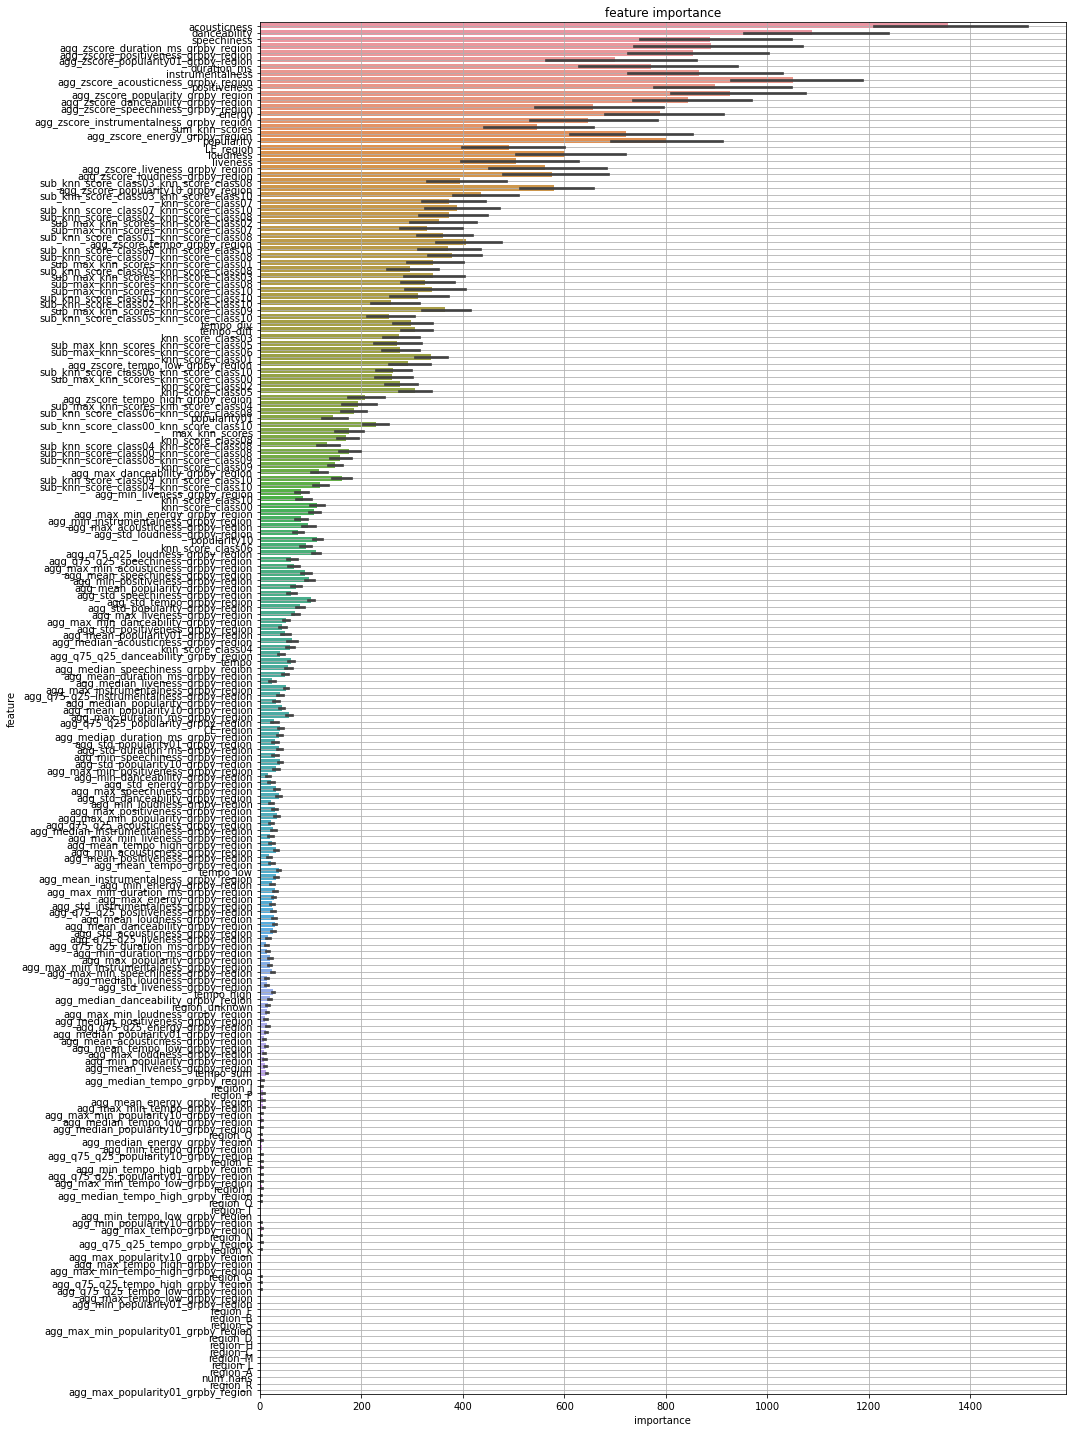

In [387]:
# df_test["prediction"] = predictions.argmax(1)
y_test = predictions.argmax(1)
score = f1_score(target, oof.argmax(1), average="macro")
print("CV score")
print(f"  f1: {score:8.5f}")
print()
print(classification_report(target, oof.argmax(1)))

plt.figure(figsize=(15, 20))
sns.barplot(x="importance", y="feature", data=df_feature_importance.sort_values(by="importance", ascending=False))
plt.title("feature importance")
plt.grid()
plt.tight_layout()
plt.show()

In [382]:
# feature importanceが0の特徴量
df_train.columns[np.where(model.feature_importance()==0)]

Index(['tempo_high', 'tempo_sum', 'tempo_diff', 'tempo_div', 'region_B',
       'region_C', 'region_D', 'region_F', 'region_G', 'region_H', 'region_I',
       'region_K', 'region_N', 'region_S', 'agg_max_duration_ms_grpby_region',
       'agg_median_energy_grpby_region', 'agg_median_liveness_grpby_region',
       'agg_median_instrumentalness_grpby_region',
       'agg_std_energy_grpby_region', 'agg_std_liveness_grpby_region',
       'agg_q75_q25_danceability_grpby_region',
       'agg_q75_q25_loudness_grpby_region', 'agg_q75_q25_energy_grpby_region',
       'agg_zscore_positiveness_grpby_region',
       'agg_zscore_liveness_grpby_region'],
      dtype='object')

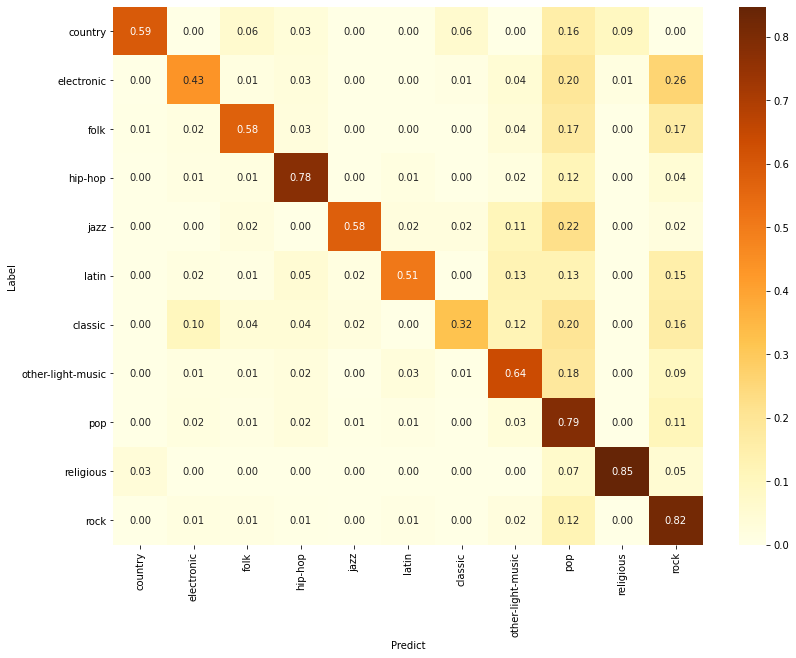

In [383]:
def visualize_confusion_matrix(y_true, pred_label, height=.6, labels=None):  # from https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    conf = confusion_matrix(y_true=y_true, y_pred=pred_label, normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 2, size * 1.5))
    sns.heatmap(conf, cmap='YlOrBr', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    return fig

    
oof_label = pd.Series(np.argmax(oof, axis=1))
fig = visualize_confusion_matrix(y_true=target, pred_label=oof_label, labels=df_genre_labels["genre"])
plt.show(fig)

## 7. Save Result

In [384]:
# Save csv file
sample_submit = pd.read_csv("../data/sample_submit.csv", header=None)
submit = pd.concat([sample_submit.iloc[:, 0], pd.Series(y_test)], axis=1)
submit.columns = ["index", "genre"]

In [385]:
submit

,index,genre
0,4046,7
1,4047,10
2,4048,10
3,4049,8
4,4050,8
...,...,...
4041,8087,10
4042,8088,8
4043,8089,1
4044,8090,8


In [386]:
# submit.to_csv("../logs/lgbmknn_v5.csv", header=None, index=None)